In [1]:
# load the package
include("../FractionalFlow/FractionalFlow.jl")
using PyPlot, SetPyPlot, NLopt, Dierckx
import Calculus
import GR
FF = FractionalFlow

FractionalFlow

# Water-flooding

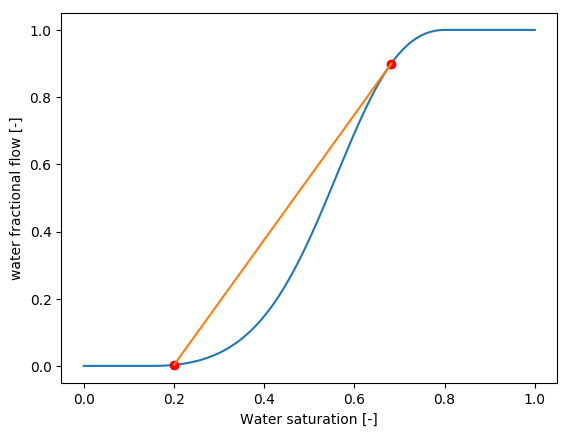

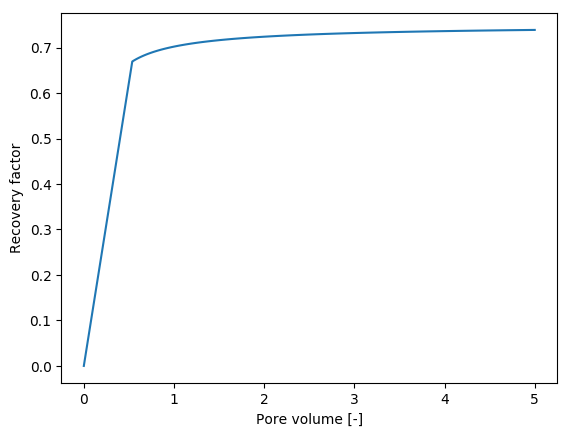

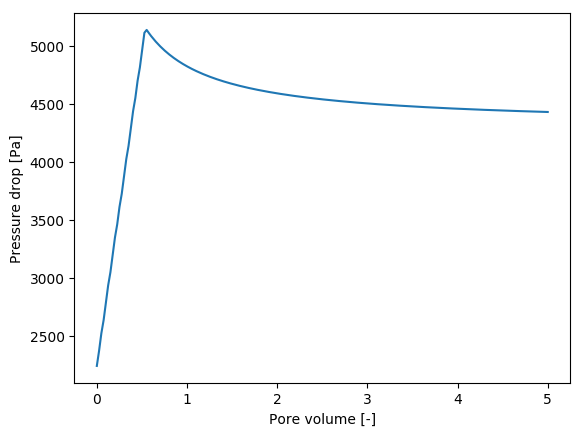

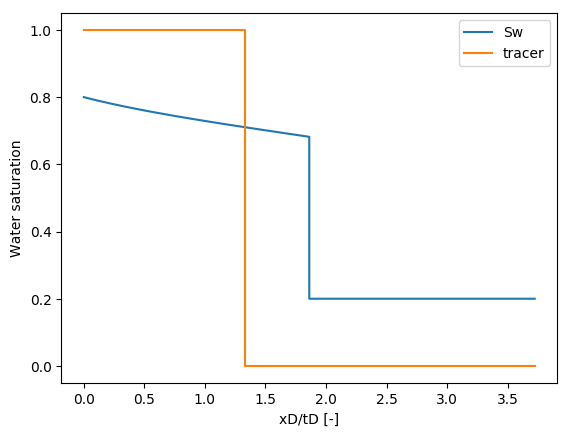

PyObject <matplotlib.legend.Legend object at 0x7fd373dbd410>

In [2]:
# define the problem
# relative permeabilities
rel_perms = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
    swc=0.15, sor=0.2, nw=2.0, no = 2.0)
# FF.visualize(rel_perms)
# define the fluids
fluids = FF.oil_water_fluids(mu_water=1e-3, mu_oil=1e-3)

# define the fractional flow functions
fw, dfw = FF.fractional_flow_function(rel_perms, fluids)
# visualize the fractional flow
# FF.visualize(rel_perms, fluids, label="lowsal")
# tight_layout()
core_flood = FF.core_flooding(u_inj=1.15e-5, pv_inject=5, 
    p_back=1e5, sw_init=0.2, sw_inj=1.0, rel_perms=rel_perms)
core_props = FF.core_properties()
wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
fw, dfw = FF.fractional_flow_function(rel_perms, fluids)
sw_tmp = linspace(0,1,100)

FF.visualize(wf_res)

In [3]:
# t_sec, pv, rec_fact, dp_core, x, sw, c, c_out_sal=
#             FF.water_flood_numeric(core_props, fluids, rel_perms, core_flood)

In [4]:
# figure()
# plot(t_sec, rec_fact, "o", wf_res.recovery_time[:,1], wf_res.recovery_time[:,2])
# figure()
# plot(t_sec, dp_core, "o", wf_res.dp_time[:,1], wf_res.dp_time[:,2])

# synthetic experimental data


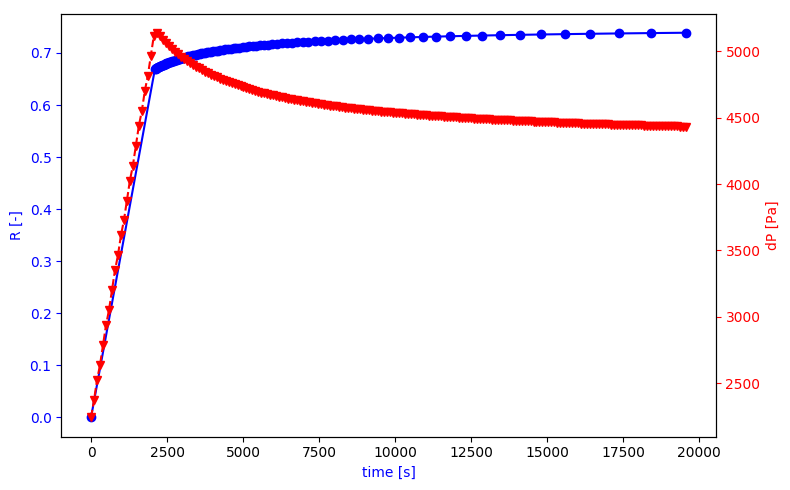

(PyPlot.Figure(PyObject <Figure size 800x500 with 2 Axes>), PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fd373d786d0>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fd373378dd0>)

In [5]:
t_exp_dp = wf_res.dp_time[:,1]
dp_exp = wf_res.dp_time[:,2]
t_exp_R = wf_res.recovery_time[:,1]
R_exp = wf_res.recovery_time[:,2]
plotyy(t_exp_R, R_exp, t_exp_dp, dp_exp, fig_size = [8,5], x_label="time [s]", y1_label="R [-]", y2_label="dP [Pa]")

# define the objective function

In [6]:
# struct
struct exp_data
    t_exp_dp
    dp_exp
    t_exp_R
    R_exp
end
exp_data1 = exp_data(t_exp_dp, dp_exp, t_exp_R, R_exp)

exp_data(Real[0.0, 98.3177, 196.635, 294.953, 393.271, 491.588, 589.906, 688.224, 786.541, 884.859  …  18680.4, 18778.7, 18877.0, 18975.3, 19073.6, 19171.9, 19270.3, 19368.6, 19466.9, 19565.2], Real[2242.5, 2373.63, 2523.48, 2637.26, 2786.82, 2936.46, 3050.13, 3199.71, 3349.32, 3462.97  …  4436.68, 4436.06, 4435.44, 4434.84, 4434.23, 4433.64, 4433.05, 4432.46, 4431.88, 4431.31], Real[0.0, 2102.05, 2123.61, 2145.64, 2168.16, 2191.17, 2214.69, 2238.73, 2263.31, 2288.44  …  12317.7, 12863.9, 13456.0, 14100.1, 14803.1, 15573.4, 16421.2, 17358.6, 18400.4, 19565.2], Real[0.0, 0.669421, 0.670104, 0.670788, 0.671473, 0.67216, 0.672849, 0.673539, 0.674231, 0.674924  …  0.732803, 0.733483, 0.734162, 0.734839, 0.735515, 0.736189, 0.736862, 0.737533, 0.738203, 0.738871])

In [7]:
core_flood.initial_water_saturation

0.2

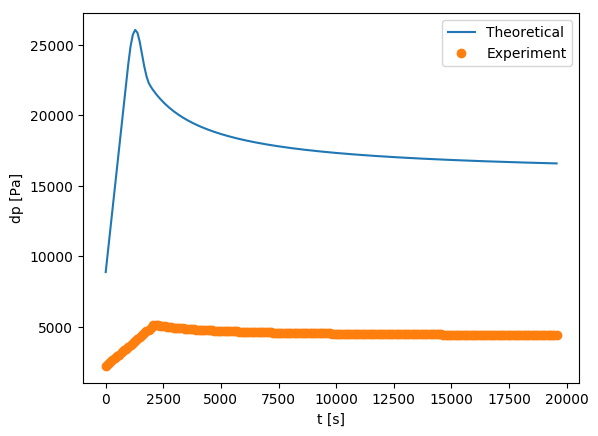

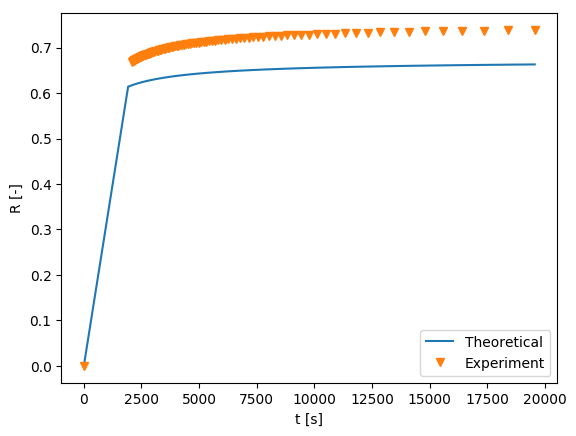

PyObject <matplotlib.legend.Legend object at 0x7fd37322e690>

In [8]:
"""
rel_perm_param [krw0, kro0, nw, no, swc, sor]
"""
function error_calc(rel_perm_param, exp_data, core_props, fluids, core_flood; w_p=1.0, w_R=1.0)
    rel_perms = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
    wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
    dp_calc = Spline1D(wf_res.dp_time[:,1], wf_res.dp_time[:,2], k=1, bc="nearest")
    R_calc = Spline1D(wf_res.recovery_time[:,1], wf_res.recovery_time[:,2], k=1, bc="nearest")
    error_dp = abs.(dp_calc(exp_data.t_exp_dp) .- exp_data.dp_exp)
#     println(error_dp)
    error_R = abs.(R_calc(exp_data.t_exp_R) .- exp_data.R_exp)
#     println(error_R)
    error_dp_norm = w_p.*error_dp./maximum(error_dp)
    error_R_norm = w_R.*error_R./maximum(error_R)
    return mean(error_R_norm)+mean(error_dp_norm)
end

function vis_error(rel_perm_param, exp_data, core_props, fluids, core_flood)
    rel_perms = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
    wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
    figure()
    plot(wf_res.dp_time[:,1], wf_res.dp_time[:,2],  exp_data.t_exp_dp, exp_data.dp_exp, "o")
    xlabel("t [s]")
    ylabel("dp [Pa]")
    legend(["Theoretical", "Experiment"])
    
    figure()
    plot(wf_res.recovery_time[:,1], wf_res.recovery_time[:,2], exp_data.t_exp_R, exp_data.R_exp, "v")
    xlabel("t [s]")
    ylabel("R [-]")
    legend(["Theoretical", "Experiment"])
    
end

# test
x_init = [0.109681, 0.201297, 3.96653, 2.0, 0.19, 0.262231]
error_calc(x_init, exp_data1, core_props, fluids, core_flood)
vis_error(x_init, exp_data1, core_props, fluids, core_flood)


In [9]:
R_calc = Spline1D(wf_res.recovery_time[:,1], wf_res.recovery_time[:,2], k=1)

Spline1D(knots=[0.0,2102.05 … 18400.4,19565.2] (101 elements), k=1, extrapolation="nearest", residual=0.0)

# define the objective function and gradients and weight factors

In [10]:
w_p = ones(length(exp_data1.dp_exp))
w_p[indmax(exp_data1.dp_exp)] = 5

function f(x)
    return error_calc(x, exp_data1, core_props, fluids, core_flood)
end

    
function g(x)
    return Calculus.gradient(x -> error_calc(x, exp_data1, core_props, fluids, core_flood), x)
end

function obj_fun(param, grad)
    if length(grad)>0
      grad[:] = g(param)
    end
    
    return f(param)
end

# test
grad_x = zeros(6)
obj_fun([1.0, 0.8, 3, 4, 0.2, 0.2], grad_x)

1.4076361054482094

In [11]:
grad_x

6-element Array{Float64,1}:
  0.783629
  0.39986 
 -0.231633
 -0.808259
  0.708108
  0.618694

In [26]:
x_init = [0.9, 0.8, 3, 3, 0.1, 0.1]
x_lb = [0.1, 0.1, 2.0, 2.0, 0.01, 0.01]
x_ub = [1.0, 1.0, 4.0, 4.0, core_flood.initial_water_saturation, 0.3]
opt_alg=:LD_LBFGS
opt1 = Opt(opt_alg, length(x_init)) # choose the algorithm
lower_bounds!(opt1, x_lb)
upper_bounds!(opt1, x_ub)
ftol_rel!(opt1, 1e-12)
ftol_abs!(opt1, 1e-12)

min_objective!(opt1, obj_fun)
(fObjOpt, paramOpt, flag) = optimize(opt1, x_init)

in callback catch


LoadError: [91mUndefVarError: res not defined[39m

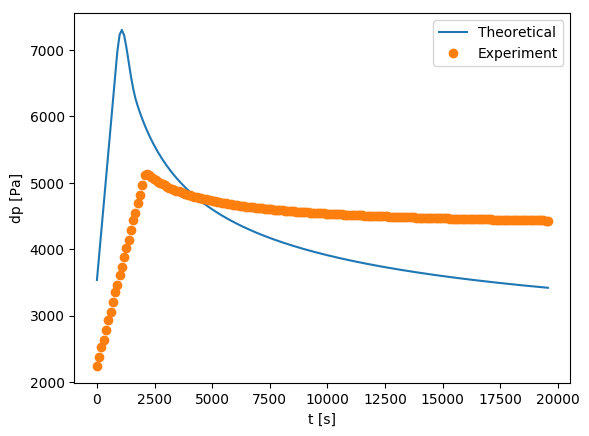

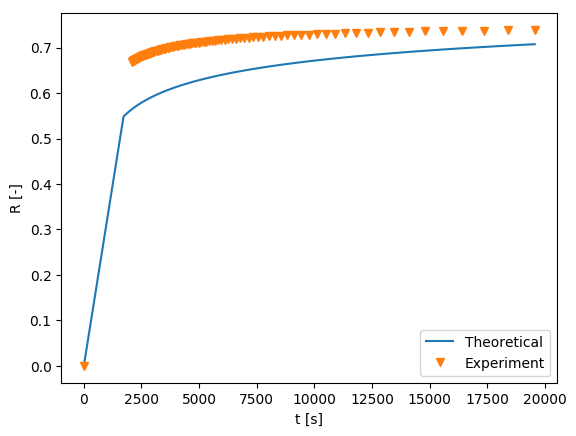

1.0062157546844388

In [24]:
x_init = paramOpt
vis_error(x_init, exp_data1, core_props, fluids, core_flood)
error_calc(x_init, exp_data1, core_props, fluids, core_flood)

# Low-sal water flooding

# Low-sal water flooding with adsorption

In [29]:
find(rand(100).>0.8)[1]

13

# Fitting the rel-perm curves

In [1]:
import Optim

In [11]:
res = Optim.optimize(x->sin(x), 0.1, 7.0, Optim.GoldenSection())

Results of Optimization Algorithm
 * Algorithm: Golden Section Search
 * Search Interval: [0.100000, 7.000000]
 * Minimizer: 4.712389e+00
 * Minimum: -1.000000e+00
 * Iterations: 36
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 37

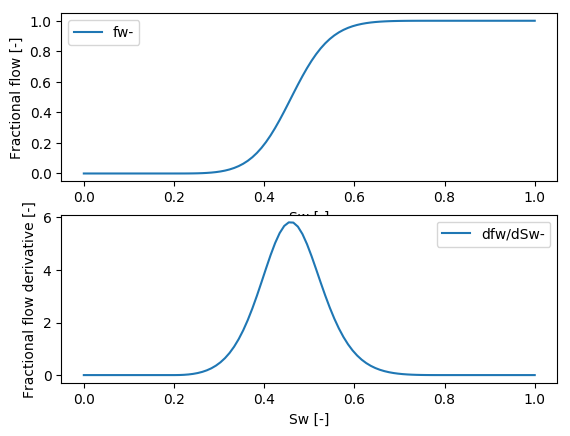

PyObject <matplotlib.legend.Legend object at 0x7f15558edb50>

In [38]:
rel_perm_param=[1.0, 0.8, 3, 4, 0.2, 0.2]
rel_perms2 = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
FF.visualize(rel_perms2, fluids)